## PTID-CDS-DEC-24-2243

## PRCP- 1001- RiceLeaf disease detection

### Problem Statement

Task 1:-Prepare a complete data analysis report on the given data.

Task 2:-Create a model which can classify the three major attacking diseases of
rice plants like leaf blast, bacterial blight and brown spot.

Task 3:- Analyze various techniques like Data Augmentation, etc and create a
report on that.

### Dataset Description

This dataset contains 120 jpg images of disease-infected rice leaves. The images are grouped into 3
classes based on the type of disease. There are 40 images in each class.

Classes

● Leaf smut

● Brown spot

● Bacterial leaf blight

### Business Case : To classify Rice Leaf Disease using CNN

In [1]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style ("dark")

import pandas as pd
import numpy as np
import itertools
import cv2
import PIL
import skimage.transform as st

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import load_img,img_to_array

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from keras.layers import Flatten,Dense
from keras.models import Model


from kerastuner import RandomSearch

import tensorflow_hub as hub
from keras.applications.vgg16 import VGG16

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

<ipython-input-2-fa1b0816faf6>:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


##### Loading the dataset

In [3]:
import pathlib
from google.colab import drive
drive.mount('/content/drive')
data_dir = pathlib.Path('/content/drive/MyDrive/Data')

#data_dir = pathlib.Path('C:/Users/User/Desktop/PTID-CDS-SEP-22-1370A_Internship/PTID-CDS-SEP-22-1370A_Internship/PRCP-1001-RiceLeaf/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# finding total number of images in the directory
image_count = len(list(data_dir.glob('*/*')))
print('we have {} files in the directory'.format(image_count))

we have 119 files in the directory


In [5]:
# Creating the dictionary with respect to rice leaf disease using directory path
rice_leaf_images_dict = {
    'leaf_smut': list(data_dir.glob('*smut/*')),
    'brown_spot': list(data_dir.glob('Brown*/*')),
    'bacterial_leaf_blight': list(data_dir.glob('Bacterial*/*')),
}

In [8]:
rice_leaf_images_dict['leaf_smut'][:5]

[PosixPath('/content/drive/MyDrive/Data/Leaf smut/DSC_0514.jpg'),
 PosixPath('/content/drive/MyDrive/Data/Leaf smut/DSC_0504.jpg'),
 PosixPath('/content/drive/MyDrive/Data/Leaf smut/DSC_0313.JPG'),
 PosixPath('/content/drive/MyDrive/Data/Leaf smut/DSC_0503.jpg'),
 PosixPath('/content/drive/MyDrive/Data/Leaf smut/DSC_0500.jpg')]

In [9]:
rice_leaf_images_dict['brown_spot'][:5]

[PosixPath('/content/drive/MyDrive/Data/Brown spot/DSC_0109.jpg'),
 PosixPath('/content/drive/MyDrive/Data/Brown spot/DSC_0119.jpg'),
 PosixPath('/content/drive/MyDrive/Data/Brown spot/DSC_0324.JPG'),
 PosixPath('/content/drive/MyDrive/Data/Brown spot/DSC_0394.jpg'),
 PosixPath('/content/drive/MyDrive/Data/Brown spot/DSC_0391.jpg')]

In [10]:
rice_leaf_images_dict['bacterial_leaf_blight'][:5]

[PosixPath('/content/drive/MyDrive/Data/Bacterial leaf blight/DSC_0398.JPG'),
 PosixPath('/content/drive/MyDrive/Data/Bacterial leaf blight/DSC_0403.JPG'),
 PosixPath('/content/drive/MyDrive/Data/Bacterial leaf blight/DSC_0399.JPG'),
 PosixPath('/content/drive/MyDrive/Data/Bacterial leaf blight/DSC_0389.JPG'),
 PosixPath('/content/drive/MyDrive/Data/Bacterial leaf blight/DSC_0395.JPG')]

### Exploratory Data Analysis

##### Identifying Class Imbalance

[Text(0, 0, '39'), Text(0, 0, '40'), Text(0, 0, '40')]

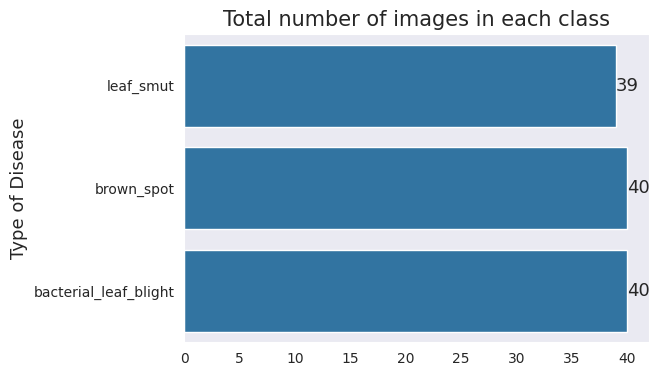

In [11]:
# Plotting total number of images present in each class
x_axis = [len(rice_leaf_images_dict['leaf_smut']),len(rice_leaf_images_dict['brown_spot']),len(rice_leaf_images_dict['bacterial_leaf_blight'])]
rice_leaf_category = ['leaf_smut','brown_spot','bacterial_leaf_blight']
plt.rcParams["figure.figsize"] =(6,4)
# Providing x and y as named arguments to sns.barplot
plot = sns.barplot(x=x_axis, y=rice_leaf_category) # Changed this line
plot.set_xlabel("", fontsize = 13)
plot.set_ylabel("Type of Disease", fontsize = 13)
plot.set_title("Total number of images in each class", fontsize = 15)
plot.bar_label(plot.containers[0], fontsize =13)

We have 40 images with brown spot and bacterial leaf blight and 39 images with leaf smut

##### Plotting Image Size

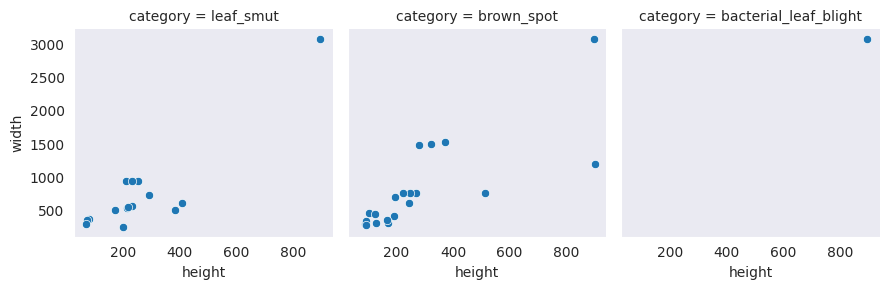

In [12]:
# Plotting image size by creating a new dataframe
class_ = []
height = []
width = []
for category in rice_leaf_images_dict.keys():
    for i in range(0,len(rice_leaf_images_dict[category])):
        im = PIL.Image.open(str(rice_leaf_images_dict[category][i]))
        arr = np.array(im)
        h,w,d = arr.shape
        class_.append(category)
        height.append(h)
        width.append(w)
df = pd.DataFrame(zip(class_,height,width),columns=['category','height','width'])
g = sns.FacetGrid(df, col="category")
g.map(sns.scatterplot, "height", "width")

We have images with different dimensions in the dataset for leaf_smut and brown spot rice leaf images. All the bacterial leaf blight rice leaf images are of same size. Image size will be resized before reading images from disk into numpy array.

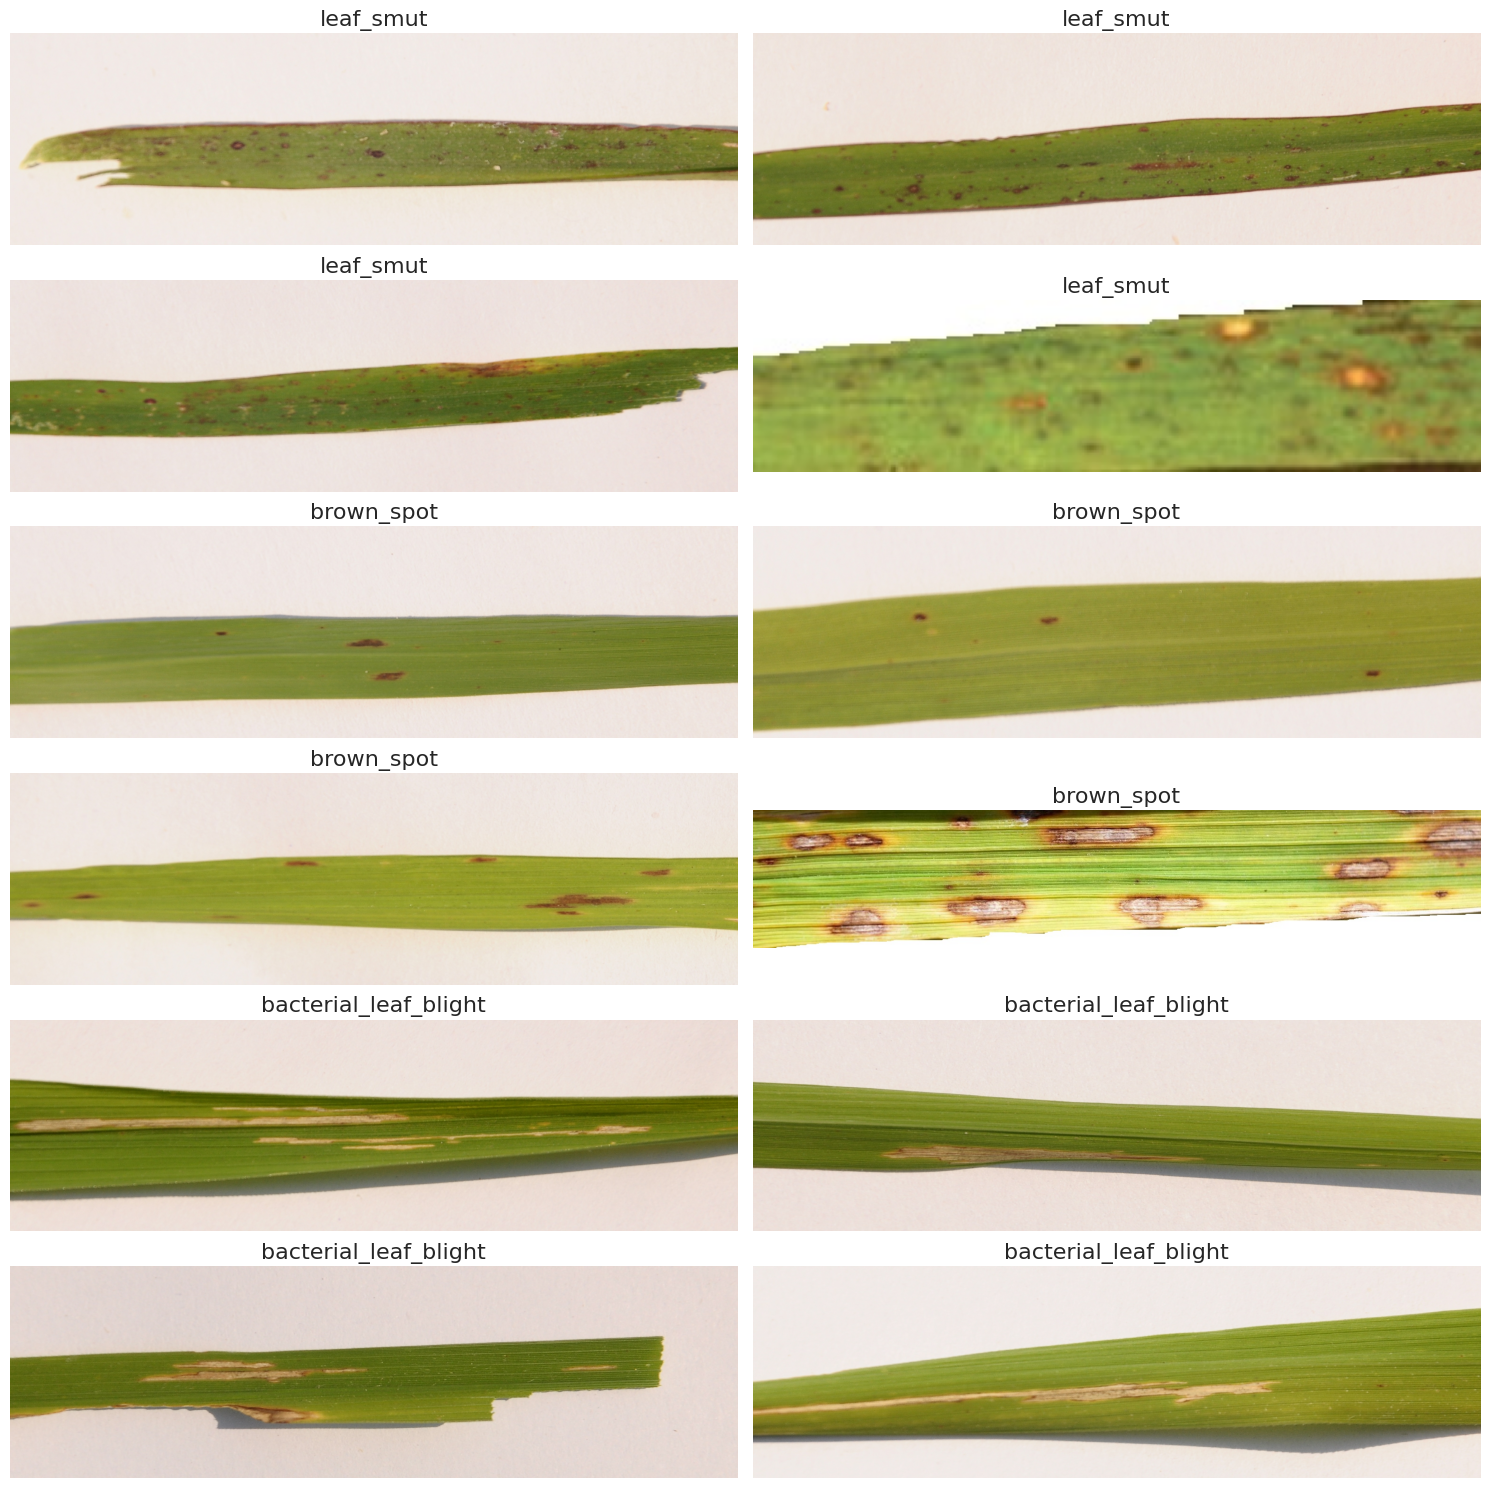

In [13]:
plt.figure(figsize=(15,15))
plotnumber = 1
for i in rice_leaf_category:
    for j in [5,15,25,37]:
        ax = plt.subplot(6,2,plotnumber)
        im1 = PIL.Image.open(str(rice_leaf_images_dict[i][j]))
        plt.imshow(im1)
        plotnumber += 1
        plt.title(i,fontsize = 16)
        plt.axis('off')
plt.tight_layout()
plt.show()

* Leaf smut : Small black spots spread across the leaves.
* Brown spot : spots are circular, brownish, and have a gray center surrounded by a reddish margin.
* Bacterial leaf blight : spots are yellowish, also looks like a dry leaf partially.

### Pre-Processing

##### Read rice leaf images from disk into numpy array using opencv

In [14]:
# Creating labels dictionary for creating y variable
rice_leaf_labels_dict = {
    'leaf_smut': 0,
    'brown_spot': 1,
    'bacterial_leaf_blight': 2,
}

In [15]:
X, y = [], []
i=0
for rice_leaf_disease,images in rice_leaf_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(250,250))
        X.append(resized_img)
        y.append(rice_leaf_labels_dict[rice_leaf_disease])

In [16]:
X = np.array(X)
y = np.array(y)

array([[[ 6, 11,  5],
        [ 7, 10,  8],
        [ 6,  8,  8],
        ...,
        [ 6, 11,  9],
        [ 6, 11,  9],
        [ 6, 11,  9]],

       [[ 6, 11,  6],
        [ 7, 10,  8],
        [ 6,  8,  8],
        ...,
        [ 6, 11,  9],
        [ 6, 11,  9],
        [ 6, 11,  9]],

       [[ 6, 11,  5],
        [ 7, 10,  8],
        [ 6,  8,  8],
        ...,
        [ 6, 11,  9],
        [ 6, 11,  9],
        [ 6, 11,  9]],

       ...,

       [[ 8, 10, 10],
        [ 8, 10, 10],
        [ 8, 10, 10],
        ...,
        [ 5,  9,  4],
        [ 5,  9,  4],
        [ 5,  9,  4]],

       [[ 8, 10, 10],
        [ 8, 10, 10],
        [ 8, 10, 10],
        ...,
        [ 5,  9,  4],
        [ 5,  9,  4],
        [ 5,  9,  4]],

       [[ 9, 11, 11],
        [ 7,  9,  9],
        [ 8, 10, 10],
        ...,
        [ 5,  9,  4],
        [ 6, 10,  5],
        [ 6, 10,  5]]], dtype=uint8)
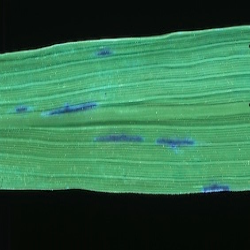

In [17]:
X[0]

In [18]:
y[0]

0

##### Traning and testing data creation

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=105,stratify=y)

In [20]:
X_train.shape

(95, 250, 250, 3)

In [21]:
y_train.shape

(95,)

In [22]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({2: 32, 0: 31, 1: 32}), Counter({2: 8, 0: 8, 1: 8}))

In [23]:
X_test.shape

(24, 250, 250, 3)

In [24]:
y_test.shape

(24,)

In [25]:
y_train

array([2, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2,
       2, 1, 0, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2,
       2, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1,
       2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1,
       2, 0, 1, 1, 2, 2, 1])

##### Scale the images


In [26]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [27]:
X_train_scaled[0]

array([[[0.85882353, 0.86666667, 0.90980392],
        [0.86666667, 0.86666667, 0.9254902 ],
        [0.85098039, 0.86666667, 0.90980392],
        ...,
        [0.86666667, 0.87843137, 0.92156863],
        [0.8627451 , 0.8745098 , 0.92941176],
        [0.85882353, 0.86666667, 0.91764706]],

       [[0.85098039, 0.86666667, 0.90980392],
        [0.85882353, 0.8627451 , 0.91764706],
        [0.85098039, 0.8627451 , 0.91764706],
        ...,
        [0.85098039, 0.8745098 , 0.9254902 ],
        [0.85882353, 0.8745098 , 0.91764706],
        [0.8627451 , 0.86666667, 0.92156863]],

       [[0.85490196, 0.86666667, 0.91764706],
        [0.85490196, 0.8627451 , 0.91764706],
        [0.85882353, 0.87058824, 0.9254902 ],
        ...,
        [0.85098039, 0.87843137, 0.92941176],
        [0.85882353, 0.8745098 , 0.91372549],
        [0.8627451 , 0.86666667, 0.92156863]],

       ...,

       [[0.83529412, 0.85490196, 0.91372549],
        [0.83921569, 0.8627451 , 0.90588235],
        [0.83921569, 0

In [28]:
X_test_scaled[0]

array([[[0.89803922, 0.90980392, 0.94117647],
        [0.89803922, 0.91372549, 0.9372549 ],
        [0.89803922, 0.90980392, 0.94117647],
        ...,
        [0.85882353, 0.88235294, 0.9254902 ],
        [0.87058824, 0.88627451, 0.92941176],
        [0.86666667, 0.88235294, 0.9254902 ]],

       [[0.89803922, 0.90980392, 0.94117647],
        [0.89803922, 0.90980392, 0.94117647],
        [0.89803922, 0.90588235, 0.94509804],
        ...,
        [0.8627451 , 0.88627451, 0.92941176],
        [0.87058824, 0.88627451, 0.92941176],
        [0.86666667, 0.88235294, 0.9254902 ]],

       [[0.89803922, 0.90980392, 0.9372549 ],
        [0.88235294, 0.90588235, 0.93333333],
        [0.88627451, 0.90588235, 0.94117647],
        ...,
        [0.8627451 , 0.89019608, 0.9372549 ],
        [0.8627451 , 0.88627451, 0.92941176],
        [0.8627451 , 0.88627451, 0.92941176]],

       ...,

       [[0.87843137, 0.89803922, 0.93333333],
        [0.8745098 , 0.89411765, 0.92941176],
        [0.87058824, 0

### Model Creation



##### Implementing Convolutional Neural Network


In [29]:
# Initialising the CNN
cnn = models.Sequential()
# Adding 1st convolution layer
cnn.add(layers.Conv2D(filters=62,padding='same', kernel_size=(3, 3),strides=3, activation='relu', input_shape=(250, 250, 3)))
# Adding 1st Maxpooling layer
cnn.add(layers.MaxPooling2D(pool_size=(2,2), strides=1))
# Adding 2nd convolution layer
cnn.add(layers.Conv2D(filters=124,padding='same', kernel_size=(3, 3),strides=1, activation='relu'))
# Adding 2nd Maxpooling layer
cnn.add(layers.MaxPooling2D(pool_size=(2,2), strides=1))
# Flattening
cnn.add(layers.Flatten())
# Input Layer
cnn.add(layers.Dense(124, activation='relu'))

#Output Layer
cnn.add(layers.Dense(3, activation='softmax'))

# Compile the model
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
cnn.fit(X_train_scaled, y_train,validation_split=0.2, epochs=25,batch_size=20)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.3788 - loss: 36.9174 - val_accuracy: 0.5789 - val_loss: 2.6560
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.4759 - loss: 2.4526 - val_accuracy: 0.4211 - val_loss: 1.0985
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.3890 - loss: 1.1604 - val_accuracy: 0.4211 - val_loss: 1.0021
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6357 - loss: 1.0374 - val_accuracy: 0.5263 - val_loss: 1.3324
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5885 - loss: 0.8383 - val_accuracy: 0.5789 - val_loss: 0.7883
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6939 - loss: 0.6348 - val_accuracy: 0.6316 - val_loss: 0.6091
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8277 - loss: 0.4879 - val_accuracy: 0.7368 - val_loss: 0.6655
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8862 - loss: 0.3266 - val_accuracy: 0.7895 - val_loss: 0.5070
Epoch 9

In [30]:
# Model evaluation
cnn.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step - accuracy: 0.5833 - loss: 1.2965


[1.2964643239974976, 0.5833333134651184]

In [31]:
y_pred = cnn.predict(X_test_scaled)
y_pred[:5]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


array([[5.9837716e-06, 1.8388455e-01, 8.1610948e-01],
       [2.6995796e-01, 7.2708035e-01, 2.9615858e-03],
       [2.0056549e-01, 4.3699309e-01, 3.6244142e-01],
       [1.4461015e-03, 2.9231790e-01, 7.0623600e-01],
       [3.4830696e-03, 9.9648970e-01, 2.7160122e-05]], dtype=float32)

In [32]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:24]

[2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2]

In [33]:
# Classification report
print(classification_report(y_test,y_classes))

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.46      0.75      0.57         8
           2       0.70      0.88      0.78         8

    accuracy                           0.58        24
   macro avg       0.72      0.58      0.52        24
weighted avg       0.72      0.58      0.52        24



In [34]:
# view the structure of the model
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 84, 84, 62)          │           1,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 83, 83, 62)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 83, 83, 124)         │          69,316 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 82, 82, 124)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 833776)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 124)                 │     103,388,348 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,379,327 (1.16 GB)

 Trainable params: 103,459,775 (394.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,919,552 (789.34 MB)

Model is overfitting, so data augmentation is required to create a generalized model.

##### Data Augmentation by adding layers using Keras.Sequential and adding  a drop out layer

In [35]:
# Creating Data Augmentation object to be used in the model creation
data_augmentation = keras.Sequential(
    [
    layers.RandomRotation(0.1,input_shape=(250, 250, 3)), # Changed to layers.RandomRotation
    layers.RandomZoom(0.1), # Changed to layers.RandomZoom
    layers.RandomFlip("horizontal"), # Changed to layers.RandomFlip
    layers.RandomContrast(0.1)]) # Changed to layers.RandomContrast

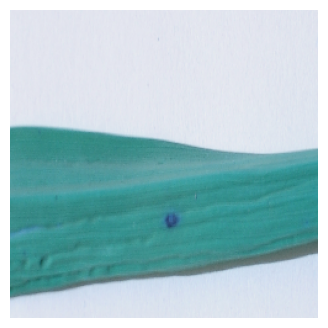

In [36]:
# Plotting image in the X_train
plt.axis('off')
plt.imshow(X_train[38])

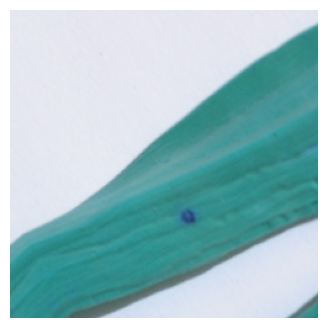

In [37]:
# Plotting the augmented image
plt.axis('off')
plt.imshow(data_augmentation(X_train)[38].numpy().astype("uint8"))

In [38]:
#Train the model using data augmentation and a drop out layer
# Initialising the CNN
cnn_da = models.Sequential()

# Adding data augmentation
cnn_da.add(data_augmentation)

# Adding 1st convolution layer
cnn_da.add(layers.Conv2D(filters=62,padding='same', kernel_size=(3, 3),strides=3, activation='relu', input_shape=(250, 250, 3)))

# Adding 1st Maxpooling layer
cnn_da.add(layers.MaxPooling2D(pool_size=(2,2), strides=1))

# Adding 2nd convolution layer
cnn_da.add(layers.Conv2D(filters=124,padding='same', kernel_size=(3, 3),strides=1, activation='relu'))

# Adding 2nd Maxpooling layer
cnn_da.add(layers.MaxPooling2D(pool_size=(2,2), strides=1))

#Dropout layer
cnn_da.add(layers.Dropout(rate=0.3))

# Flattening
cnn_da.add(layers.Flatten())

# Input Layer
cnn_da.add(layers.Dense(124, activation='relu'))

#Output Layer
cnn_da.add(layers.Dense(3, activation='softmax'))

# Compile the model
cnn_da.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn_da= cnn_da.fit(X_train_scaled, y_train, validation_split=0.2, epochs=25,batch_size=20)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.3718 - loss: 17.1766 - val_accuracy: 0.4737 - val_loss: 19.8758
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.2572 - loss: 15.6131 - val_accuracy: 0.3158 - val_loss: 1.1061
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.4246 - loss: 1.0902 - val_accuracy: 0.4211 - val_loss: 1.0853
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5108 - loss: 1.0713 - val_accuracy: 0.4211 - val_loss: 1.0331
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4925 - loss: 1.0772 - val_accuracy: 0.3158 - val_loss: 1.5694
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4303 - loss: 1.0955 - val_accuracy: 0.6316 - val_loss: 0.9391
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6032 - loss: 0.9514 - val_accuracy: 0.6842 - val_loss: 0.7824
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5352 - loss: 0.8757 - val_accuracy: 0.5789 - val_loss: 0.7949
Epoch

In [39]:
#Creating function to plot loss and accuracy with respect to epochs
def plot_loss_and_acccuracy(model):
# plot the loss
  plt.plot(model.history['loss'], label='train loss')
  plt.plot(model.history['val_loss'], label='val loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
# plot the accuracy
  plt.plot(model.history['accuracy'], label='train acc')
  plt.plot(model.history['val_accuracy'], label='val acc')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

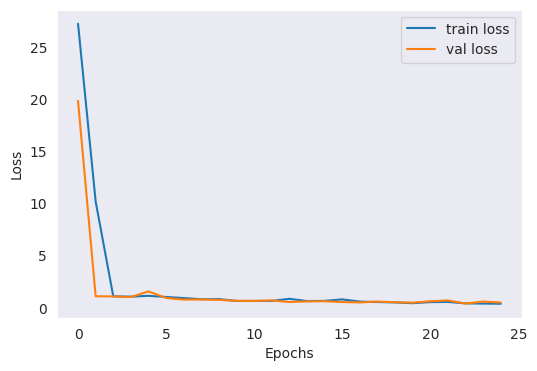

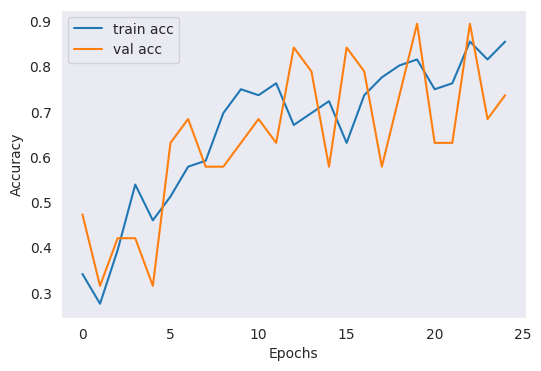

In [40]:
#Plotting loss and accuracy with respect to epochs
plot_loss_and_acccuracy(history_cnn_da)

In [41]:
# Model evaluation
cnn_da.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - accuracy: 0.5833 - loss: 0.9078


[0.9078403115272522, 0.5833333134651184]

In [42]:
y_pred_da = cnn_da.predict(X_test_scaled)
y_pred_da[:5]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


array([[6.0756161e-04, 9.4651949e-01, 5.2872840e-02],
       [2.2153530e-01, 7.2200727e-01, 5.6457423e-02],
       [4.1875368e-01, 1.3904333e-01, 4.4220296e-01],
       [4.0643946e-03, 3.5863331e-01, 6.3730234e-01],
       [2.7605634e-02, 9.6889466e-01, 3.4996658e-03]], dtype=float32)

In [43]:
y_classes_da = [np.argmax(element) for element in y_pred_da]
y_classes_da[:24]

[1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1]

In [44]:
# Classification report
print(classification_report(y_test,y_classes_da))

              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.50      0.75      0.60         8
           2       0.67      0.75      0.71         8

    accuracy                           0.58        24
   macro avg       0.61      0.58      0.56        24
weighted avg       0.61      0.58      0.56        24



In [45]:
# view the structure of the model
cnn_da.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 84, 84, 62)          │           1,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 83, 83, 62)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 83, 83, 124)         │          69,316 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 82, 82, 124)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 82, 82, 124)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 833776)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 124)                 │     103,388,348 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,379,327 (1.16 GB)

 Trainable params: 103,459,775 (394.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,919,552 (789.34 MB)

Model performance is better when compared to previous model

##### Hypertuning using KerasTuner with data augmentation (add layers using Keras.Sequential)

In [46]:
# Creating function to tune the parameters with the provided range
def build_model(hp):
  model = models.Sequential([
    data_augmentation, # using the data augmentation by adding layers using Keras.Sequential
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    layers.MaxPooling2D(
        pool_size=hp.Choice('max_pool_size_1', values = [2,3,4,5])
    ),
        layers.Dropout(
        rate= hp.Choice('dropout_1', values = [0.1,0.2,0.3,0.4,0.5])
    ),
    layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    layers.MaxPooling2D(
        pool_size=hp.Choice('max_pool_size_2', values = [2,3,4,5])
    ),
    layers.Dropout(
        rate= hp.Choice('dropout_2', values = [0.1,0.2,0.3,0.4,0.5])
    ),
    layers.Flatten(),
    layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    layers.Dense(3, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [47]:
# Hypertuning the model using the build_model function
tuner_search=RandomSearch(build_model,objective='val_accuracy',max_trials=50,directory='output',project_name="RiceLeaf disease detection")
tuner_search.search(X_train_scaled, y_train,epochs=3,validation_split=0.2)

Trial 50 Complete [00h 00m 59s]
val_accuracy: 0.42105263471603394

Best val_accuracy So Far: 0.5263158082962036
Total elapsed time: 01h 01m 03s


In [51]:
# Selecting the top performed model
hypertuned_model=tuner_search.get_best_models(num_models=1)[0]
# view the structure of the model
hypertuned_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 246, 246, 48)        │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 82, 82, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 82, 82, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 78, 78, 48)          │          57,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 15, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         691,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 752,755 (2.87 MB)

 Trainable params: 752,755 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
#File name includes epoch
filepath='/content/drive/MyDrive/Data/RiceLeaf_model.keras'
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('/content/drive/MyDrive/Data.csv', separator=',', append=False)

# Used callbacks to save the best models with respect to validation loss
hyper = hypertuned_model.fit(X_train_scaled,y_train, epochs=100, validation_split =0.2, batch_size = 20, callbacks = [checkpoint,early_stop, log_csv])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4296 - loss: 1.1023
Epoch 1: val_loss improved from inf to 1.09542, saving model to /content/drive/MyDrive/Data/RiceLeaf_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4174 - loss: 1.1060 - val_accuracy: 0.2632 - val_loss: 1.0954
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3659 - loss: 1.0870
Epoch 2: val_loss did not improve from 1.09542
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3638 - loss: 1.0874 - val_accuracy: 0.3158 - val_loss: 1.0988
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4207 - loss: 1.0882
Epoch 3: val_loss did not improve from 1.09542
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4182 - loss: 1.0869 - val_accuracy: 0.3158 - val_loss: 1.1037
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3564 - loss: 1.0799
Epoch 4: val_loss did not improve from 1.09542
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.3535 - loss: 1.0804 - val_ac

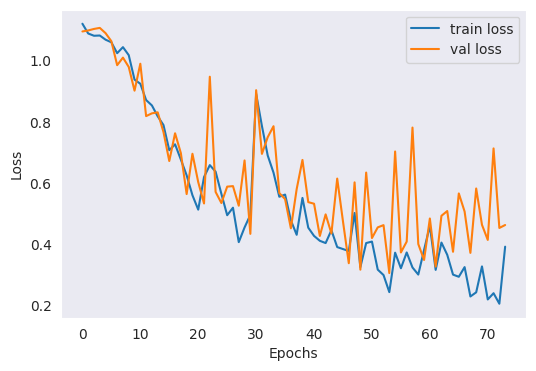

In [63]:
#Plotting loss and accuracy with respect to epochs
plot_loss_and_acccuracy(hyper)

In [65]:
# Creating a dataframe to have a look into the results
loss_and_accuracy = pd.read_csv('/content/drive/MyDrive/Data.csv')
epoch_no =[1,2,11,12,13,22,36,37,38,39,40]#saved models epochno
loss_and_accuracy.loc[epoch_no]

epoch  accuracy      loss  val_accuracy  val_loss
1       1  0.355263  1.088804      0.315789  1.098773
2       2  0.407895  1.081401      0.315789  1.103675
11     11  0.565789  0.871549      0.684211  0.819069
12     12  0.657895  0.853863      0.578947  0.828005
13     13  0.618421  0.818436      0.473684  0.831384
22     22  0.697368  0.658980      0.631579  0.947663
36     36  0.815789  0.478604      0.842105  0.452614
37     37  0.855263  0.431451      0.789474  0.580753
38     38  0.815789  0.551924      0.736842  0.675869
39     39  0.815789  0.454768      0.789474  0.538156
40     40  0.855263  0.427851      0.736842  0.532914

Epoch40 seems to be the best generalized model with minimum loss

In [72]:
# load best model using the checkpoint
# The original file path might be incorrect.
# Make sure the file 'RiceLeaf_model.keras' exists in the specified directory
best_model = load_model('/content/drive/MyDrive/Data/RiceLeaf_model.keras')

# Model evaluation
best_model.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7083 - loss: 0.6580


[0.6579553484916687, 0.7083333134651184]

In [73]:
y_pred_hyper = best_model.predict(X_test_scaled)
y_pred_hyper[:5]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[2.0791485e-03, 7.0882809e-01, 2.8909263e-01],
       [9.9311924e-01, 6.3891448e-03, 4.9170112e-04],
       [2.6041543e-01, 1.4572725e-01, 5.9385729e-01],
       [5.1015425e-02, 8.0681533e-01, 1.4216924e-01],
       [8.3233523e-01, 1.6698521e-01, 6.7951647e-04]], dtype=float32)

In [74]:
y_classes_hyper = [np.argmax(element) for element in y_pred_hyper]
y_classes_hyper[:24]

[1, 0, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1]

In [75]:
# Classification report
print(classification_report(y_test,y_classes_hyper))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         8
           2       0.71      0.62      0.67         8

    accuracy                           0.71        24
   macro avg       0.72      0.71      0.71        24
weighted avg       0.72      0.71      0.71        24



Hypertuned model gives us the better result than previous model with accuracy 0.79 and the loss is 2.89

##### Data Augmentation using Image generator

In [86]:
# Generating augmented images using ImageDataGenerator in Keras
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    vertical_flip=True
)

# creating list of index for labels present in Training dataset
label_0 = list(itertools.chain(*np.where(y_train == 0)))
label_1 = list(itertools.chain(*np.where(y_train == 1)))
label_2 = list(itertools.chain(*np.where(y_train == 2)))

import os

# ... (your existing code) ...

# Creating paths for each label to store files in each label
# Updated paths to ensure they are accessible within Colab
path_label_0 = '/content/drive/MyDrive/Data/label_0'
path_label_1 = '/content/drive/MyDrive/Data/label_1'
path_label_2 = '/content/drive/MyDrive/Data/label_2'

# Create the directories if they don't exist
for path in [path_label_0, path_label_1, path_label_2]:
    os.makedirs(path, exist_ok=True)

# ... (rest of your code) ...

def image_generator(label,path):
  import os # Importing the os module
  augment = 0
  for index in label:
    img = X_train[index] # Taking images in X_train using index
    img = img.reshape((1,) + img.shape)  # Reshaping the image
    #save_here = os.path.join(path,str(augment)+".png") # path to store augmented images # This line is not used
    # this loop runs for 20 times and augments the image and stores in the defined path
    for batch in datagen.flow(img, batch_size=1,save_to_dir=path, save_prefix='aug', save_format='png'):
      augment += 1
      if augment >= 20:
        break
  print("Augmented Images generated in {} folder".format(path))

image_generator(label_0,path_label_0)
image_generator(label_1,path_label_1)
image_generator(label_2,path_label_2)

Augmented Images generated in /content/drive/MyDrive/Data/label_0 folder
Augmented Images generated in /content/drive/MyDrive/Data/label_1 folder
Augmented Images generated in /content/drive/MyDrive/Data/label_2 folder


In [87]:
len(list(data_dir.glob('*label_0/*')))

50

In [88]:
len(list(data_dir.glob('*label_1/*')))

51

In [89]:
len(list(data_dir.glob('*label_2/*')))

51

In [90]:
path_0 = list(data_dir.glob('label_0/*'))
path_1 = list(data_dir.glob('label_1/*'))
path_2 = list(data_dir.glob('label_2/*'))

# Creating function to create the data using the augmented images by specifying the path
def create_data_from_image(path):
  data = []
  for image in path:
    img = cv2.imread(str(image))
    data.append(img)
  return data

# Data creation
label_0_data = create_data_from_image(path_0)
label_1_data = create_data_from_image(path_1)
label_2_data = create_data_from_image(path_2)

# Combining data and converting into Augmented data numpy array
augmented_data = np.array(label_0_data+label_1_data+label_2_data)

#Combining the labels for the augmented data and converting it into Augmented labels numpy array
augmented_labels = np.array(([0] * len(label_0_data)) + ([1] * len(label_1_data)) + ([2] * len(label_2_data)))

# Combing augmented data with the training data, so this can be used for training data
X_train_augmented = np.concatenate([X_train,augmented_data])
y_train_augmented = np.concatenate([y_train,augmented_labels])

#scaling the data to use this for training
X_train_augmented = X_train_augmented / 255

In [91]:
X_train_augmented.shape

(247, 250, 250, 3)

In [92]:
y_train_augmented.shape

(247,)

##### Hypertuning using Keras tuner using data with Image Data generator

In [93]:
# Hypertuning using build model function created earlier
tuner_search1=RandomSearch(build_model,objective='val_accuracy',max_trials=10,directory='output',project_name="RiceLeaf disease detection")
tuner_search1.search(X_train_augmented, y_train_augmented,epochs=10,validation_split=0.2)

Reloading Tuner from output/RiceLeaf disease detection/tuner0.json


In [94]:
# Selecting the top performed model
datagen_hypertuned_model=tuner_search1.get_best_models(num_models=1)[0]
# View the structure of the model
datagen_hypertuned_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 246, 246, 112)       │           8,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 112)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 61, 61, 112)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 80)          │         224,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 19, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,848,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081,171 (7.94 MB)

 Trainable params: 2,081,171 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
import os

#File name includes epoch
filepath='/content/drive/MyDrive/Colab Notebooks/PTID-CDS-SEP-22-1370A_Internship/PRCP-1001-RiceLeaf/datagen_Hypertuned_models/datagen_hypertuned_model_{epoch:02d}.keras' # Changed the file extension to .keras.hdf5'

#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
# Create the directory if it doesn't exist
log_dir = '/content/drive/MyDrive/Colab Notebooks/PTID-CDS-SEP-22-1370A_Internship/PRCP-1001-RiceLeaf/datagen_Hypertuned_models/'
os.makedirs(log_dir, exist_ok=True)

log_csv = CSVLogger(os.path.join(log_dir, 'my_logs.csv'), separator=',', append=False)


# Used callbacks to save the best models with respect to validation loss
datagen_hyper = datagen_hypertuned_model.fit(X_train_scaled,y_train, epochs=100, validation_split =0.2, batch_size = 20, callbacks = [checkpoint,early_stop, log_csv])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3855 - loss: 1.1008
Epoch 1: val_loss improved from inf to 1.09468, saving model to /content/drive/MyDrive/Colab Notebooks/PTID-CDS-SEP-22-1370A_Internship/PRCP-1001-RiceLeaf/datagen_Hypertuned_models/datagen_hypertuned_model_01.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.3768 - loss: 1.1014 - val_accuracy: 0.2632 - val_loss: 1.0947
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3293 - loss: 1.1000
Epoch 2: val_loss did not improve from 1.09468
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.3318 - loss: 1.1000 - val_accuracy: 0.2632 - val_loss: 1.1001
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3230 - loss: 1.0995
Epoch 3: val_loss did not improve from 1.09468
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.3268 - loss: 1.0994 - val_accuracy: 0.2632 - val_loss: 1.1073
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4043 - loss: 1.0966
Epoch 4: val_loss did no

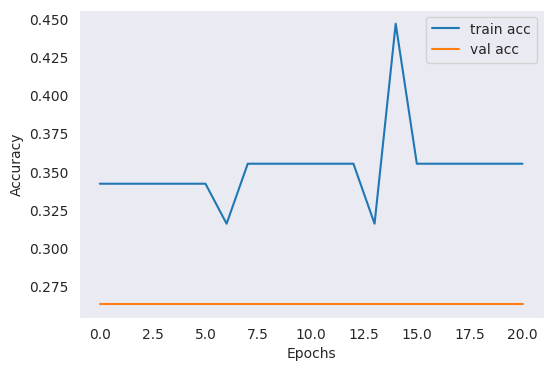

In [98]:
#Plotting loss and accuracy with respect to epochs
plot_loss_and_acccuracy(datagen_hyper)

In [100]:
# Creating a dataframe to view the results
loss_and_accuracy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PTID-CDS-SEP-22-1370A_Internship/PRCP-1001-RiceLeaf/datagen_Hypertuned_models/my_logs.csv')
epoch_no =[1,2,5,16,20]#saved models epochno
loss_and_accuracy.loc[epoch_no]

epoch  accuracy      loss  val_accuracy  val_loss
1       1  0.342105  1.100061      0.263158  1.100053
2       2  0.342105  1.099221      0.263158  1.107257
5       5  0.342105  1.097355      0.263158  1.121454
16     16  0.355263  1.098238      0.263158  1.107659
20     20  0.355263  1.097267      0.263158  1.112199

Model created using Image generator is not performing good for this dataset

### Conclusion

#### CNN model with data augmentation(add layers using Keras.Sequential) performed better than other models.
Note: Hyperparameter tuning done using KerasTuner

Train Accuracy : 1.000000

Train loss : 0.003757

val_accuracy : 0.947368

val_loss : 0.563688

Test accuracy : 0.791666

Test loss : 2.890278

In [119]:
# load better performing model
# Updated path to the correct location, ensuring the .keras extension is used
best_model = load_model('/content/drive/MyDrive/Data/RiceLeaf_model.keras')

# Model evaluation
best_model.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7083 - loss: 0.6580


[0.6579553484916687, 0.7083333134651184]

In [118]:
# view the structure of the model
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 246, 246, 48)        │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 82, 82, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 82, 82, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 78, 78, 48)          │          57,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 15, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         691,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,258,267 (8.61 MB)

 Trainable params: 752,755 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,505,512 (5.74 MB)

##### Visualizing the prediction of the model

In [120]:
plt.figure(figsize=(15,15))
plotnumber = 1
for i in range(0, len(X_test)):
        ax = plt.subplot(6,4,plotnumber)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.text(7,40, "Actual : " + list(rice_leaf_labels_dict.keys())[list(rice_leaf_labels_dict.values()).index(y_test[i])] + "\n"
        + "Predicted : " + list(rice_leaf_labels_dict.keys())[list(rice_leaf_labels_dict.values()).index(y_classes_hyper[i])],
        color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.5))
        plotnumber += 1
plt.tight_layout()
plt.show()